In [1]:
import pandas as pd
import numpy as np
import sqlite3

## Database Access and Data Retrieval

In [2]:
conn = sqlite3.connect('../res/data/tables.sql')
cursor = conn.cursor()

In [3]:
# # ['id', 'school', 'gender', 'age', 'home address', 'parents cohabitation', 'moms education', 'dads education', 'moms job', 'dads job', 'choice reason', 'guardian', 'travel time', 'nursery education', 'internet access', 'higher education', 'significant other', 'household size', 'family relationship', 'free time', 'social activities', 'study time', 'first periods grade', 'second periods grade', 'third periods grade','failures', 'absences', 'health', 'weekday drinker', 'weekend drinker', 'drinker']
 
cursor.execute('''
SELECT profile_encoded.id, school, gender, age, "home address", "parents cohabitation", 
"moms education", "dads education", "moms job", "dads job", "choice reason", 
guardian, "travel time", "nursery education", "internet access", "higher education",
"significant other", "household size", "family relationship", "free time",
"social activities", "study time", "first periods grade", "second periods grade",
"third periods grade", failures, absences, health, "weekday drinking",
"weekend drinking", "heavy drinking"
FROM profile_encoded
JOIN activities_encoded
ON profile_encoded.id = activities_encoded.id
''')

row = cursor.fetchall()
description = cursor.description
conn.close()

In [4]:
df = pd.DataFrame(data=row, columns=map(lambda x: x[0], description))
df = df.set_index('id')
df.head()

,school,gender,age,home address,parents cohabitation,moms education,dads education,moms job,dads job,choice reason,...,study time,first periods grade,second periods grade,third periods grade,failures,absences,health,weekday drinking,weekend drinking,heavy drinking
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,18,1,0,4,4,0,2,0,...,2,0,0,0,0,6,3,1,1,0
2,0,1,17,1,1,1,1,0,4,0,...,2,0,0,0,0,4,3,1,1,0
3,0,1,15,1,1,1,1,0,4,4,...,2,0,0,1,3,10,3,2,3,1
4,0,1,15,1,1,4,2,1,3,1,...,3,1,1,1,0,2,5,1,1,0
5,0,1,16,1,1,3,3,4,4,1,...,2,0,1,1,0,4,5,1,2,0


In [5]:
df.nunique()

school                   2
gender                   2
age                      8
home address             2
parents cohabitation     2
moms education           5
dads education           5
moms job                 5
dads job                 5
choice reason            4
guardian                 3
travel time              4
nursery education        2
internet access          2
higher education         2
significant other        2
household size           2
family relationship      5
free time                5
social activities        5
study time               4
first periods grade      2
second periods grade     2
third periods grade      2
failures                 4
absences                35
health                   5
weekday drinking         5
weekend drinking         5
heavy drinking           2
dtype: int64

## Data Modeling

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf

### Data Preparation

In [7]:
# Non-binary list

non_binary = ['age', 'guardian', 'failures', 'free time', 'travel time', 'social activities', 'study time', 'health', 'family relationship', 'moms job', 'dads job', 'moms education', 'dads education', 'choice reason']
non_binary.append('absences')

non_binary_df = df[non_binary]
non_binary_df[:5]

,age,guardian,failures,free time,travel time,social activities,study time,health,family relationship,moms job,dads job,moms education,dads education,choice reason
id,,,,,,,,,,,,,,
1,18,0,0,3,2,4,2,3,4,0,2,4,4,0
2,17,1,0,3,1,3,2,3,5,0,4,1,1,0
3,15,0,3,3,1,2,2,3,4,0,4,1,1,4
4,15,0,0,2,1,2,3,5,3,1,3,4,2,1
5,16,1,0,3,1,2,2,5,4,4,4,3,3,1


In [8]:
non_binary_df.dtypes

age                    int64
guardian               int64
failures               int64
free time              int64
travel time            int64
social activities      int64
study time             int64
health                 int64
family relationship    int64
moms job               int64
dads job               int64
moms education         int64
dads education         int64
choice reason          int64
dtype: object

In [9]:
one_hot_enc = OneHotEncoder(sparse=False)
one_hot_df = pd.DataFrame(one_hot_enc.fit_transform(non_binary_df))
encoded_columns = one_hot_enc.get_feature_names_out(non_binary)
one_hot_df.columns = encoded_columns

# merge dataframes

encoded_df = df.join(one_hot_df)

# drop non-binary columns
encoded_df = encoded_df.drop(non_binary, axis=1)
encoded_df[:5]

,school,gender,home address,parents cohabitation,nursery education,internet access,higher education,significant other,household size,first periods grade,...,moms education_4,dads education_0,dads education_1,dads education_2,dads education_3,dads education_4,choice reason_0,choice reason_1,choice reason_3,choice reason_4
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,0,1,0,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1,1,1,0,1,1,0,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,1,1,1,1,1,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0,1,1,1,1,0,1,0,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [10]:
encoded_df = encoded_df.dropna()

In [11]:
encoded_df.nunique()

school                  2
gender                  2
home address            2
parents cohabitation    2
nursery education       2
                       ..
dads education_4        2
choice reason_0         2
choice reason_1         2
choice reason_3         2
choice reason_4         2
Length: 83, dtype: int64

### Features (Inputs) and Target(s) (Output) 

In [12]:
features = encoded_df.columns
# features = features.drop(['heavy drinking', 'weekend drinking', 'weekday drinking', 'absences'])
features = features.drop(['heavy drinking', 'weekend drinking', 'weekday drinking'])

output = 'heavy drinking'

X = encoded_df[features]
y = encoded_df[output]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Number of Features

In [13]:
print(f'Number of Columns in the table before preprocessing: {len(df.columns)}')
print(f'Number of Features: {len(features)}')
print(f'Number of Output: 1')

Number of Columns in the table before preprocessing: 30
Number of Features: 80
Number of Output: 1


### Utility Functions

In [14]:
def feature_rank(values, columns, sort=True):
    """
    Pairs up feature names with their importance values
    
    Parameters
        values (numpy.array): array of floats from model.feature_importances_
        columns (list): list of column names from df.columns
        sort (boolean): sort list 
    
    Returns
        list of tuples containing tuples of (column-name, importance-value)
    """
    # creates an unordered list of tuple
    ranks = [(x,y) for x, y in zip(columns, values)]
    
    if(sort):
        # sorts in descending order
        return sorted(ranks, key=lambda x: x[1], reverse=True)
    else:
        return ranks

    
def matrix_dataframe(arg):
    return pd.DataFrame(data=arg, index=['Actual (Positive)', 'Actual (Negative)'], columns=['Predicted (True)', 'Predicted (False)'])


###  Data Scaled 

In [15]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Decision Tree Classifier

In [16]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
X_train_scaled

array([[-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [ 1.67215923,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
         1.82878223, -0.31600531],
       ...,
       [-0.59802917,  0.88392374,  0.61380825, ...,  1.7651599 ,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931, -1.62917329, ...,  1.7651599 ,
        -0.54681196, -0.31600531]])

### Predictions (Decision Tree Classifier)

In [17]:
dt_predictions = dt_model.predict(X_test_scaled)
dt_predictions

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1],
      dtype=int64)

### The Predictive Accuracy (Decision Tree Classifier)

In [18]:
dt_acc_score = accuracy_score(y_test, dt_predictions)
dt_acc_score

0.7164750957854407

### Confusion Matrix (Decision Tree Classifier)

In [19]:
dt_conf_mat = confusion_matrix(y_test, dt_predictions)
dt_conf_mat

array([[112,  40],
       [ 34,  75]], dtype=int64)

In [20]:
matrix_dataframe(dt_conf_mat)

,Predicted (True),Predicted (False)
Actual (Positive),112,40
Actual (Negative),34,75


### Feature Importance Rank (Decision Tree Classifier)

In [21]:
ranks = feature_rank(dt_model.feature_importances_, features)
pd.Series(data=dict(ranks), name='feature importances')[:15]  # Top 15

absences                 0.067520
gender                   0.063431
second periods grade     0.032369
choice reason_4          0.029842
health_4                 0.027571
significant other        0.027171
dads education_2         0.027159
social activities_5      0.025549
social activities_2      0.025209
moms job_3               0.024476
family relationship_4    0.023975
dads job_4               0.023606
family relationship_5    0.022784
choice reason_3          0.021734
moms education_1         0.021670
Name: feature importances, dtype: float64

### Classification Report (Decision Tree Classifier)

In [22]:
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       152
           1       0.65      0.69      0.67       109

    accuracy                           0.72       261
   macro avg       0.71      0.71      0.71       261
weighted avg       0.72      0.72      0.72       261



## Random Forest Classifier

In [23]:
rf_model = RandomForestClassifier(n_estimators=128, random_state=25)
rf_model.fit(X_train_scaled, y_train)
X_train_scaled

array([[-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [ 1.67215923,  0.88392374,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917,  0.88392374,  0.61380825, ..., -0.56652091,
         1.82878223, -0.31600531],
       ...,
       [-0.59802917,  0.88392374,  0.61380825, ...,  1.7651599 ,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931,  0.61380825, ..., -0.56652091,
        -0.54681196, -0.31600531],
       [-0.59802917, -1.13131931, -1.62917329, ...,  1.7651599 ,
        -0.54681196, -0.31600531]])

### Predictions (Random Forest Classifier)

In [24]:
rf_predictions = rf_model.predict(X_test_scaled)
rf_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

### The Predictive Accuracy (Random Forest Classifier)

In [25]:
rf_acc_score = accuracy_score(y_test, rf_predictions)
rf_acc_score

0.8084291187739464

### Confusion Matrix (Random Forest Classifier)

In [26]:
rf_conf_mat = confusion_matrix(y_test, rf_predictions)
rf_conf_mat

array([[136,  16],
       [ 34,  75]], dtype=int64)

In [27]:
matrix_dataframe(rf_conf_mat)

,Predicted (True),Predicted (False)
Actual (Positive),136,16
Actual (Negative),34,75


### Feature Importance Rank (Random Forest Classifier)

In [28]:
ranks = feature_rank(rf_model.feature_importances_, features)
pd.Series(dict(ranks), name='feature importances')[:15]

absences                0.056815
gender                  0.048699
significant other       0.019775
nursery education       0.018995
household size          0.018372
social activities_3     0.017341
choice reason_0         0.017320
study time_2            0.017278
free time_3             0.017178
moms job_4              0.017018
travel time_1           0.016994
health_5                0.016875
second periods grade    0.016573
age_16                  0.016406
home address            0.016000
Name: feature importances, dtype: float64

### Classification Report (Random Forest Classifier)

In [29]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       152
           1       0.82      0.69      0.75       109

    accuracy                           0.81       261
   macro avg       0.81      0.79      0.80       261
weighted avg       0.81      0.81      0.81       261



## Neural Network

In [30]:
# define the model

num_input_features = len(X_train_scaled[0])
hidden_nodes_layer_1 = 2
hidden_nodes_layer_2 = 15

nn = tf.keras.models.Sequential()

# first hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_1, input_dim=num_input_features, activation='relu'))

# second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer_2, activation='relu'))

# outer layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

print(f'The model loss is {model_loss} and the accuracy is {model_accuracy}')

Epoch 1/50
25/25 [==============================] - 1s 2ms/step - loss: 0.8060 - accuracy: 0.4578
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.7065 - accuracy: 0.5090
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.5882
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6330
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6204 - accuracy: 0.6573
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5993 - accuracy: 0.6944
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5788 - accuracy: 0.7136
Epoch 8/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.7404
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5400 - accuracy: 0.7596
Epoch 10/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5228 - accuracy: 0.7775
Epoch 11/50
25/25 [

### Summary (Neural Network)

In [31]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                2268      
                                                                 
 dense_1 (Dense)             (None, 14)                406       
                                                                 
 dense_2 (Dense)             (None, 1)                 15        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


## Charts

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

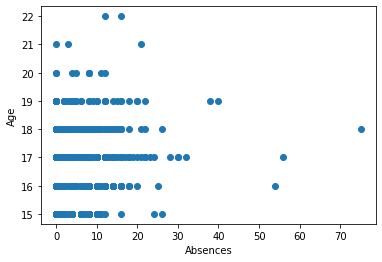

In [33]:
plt.scatter( df['absences'], df['age'])
plt.ylabel('Age')
plt.xlabel('Absences')
plt.show()

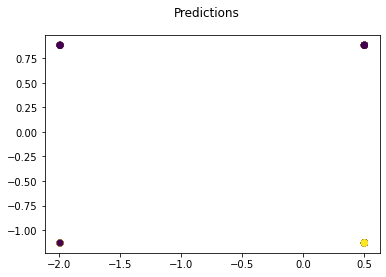

In [34]:
plt.scatter( X_test_scaled[:, 4], X_test_scaled[:, 1], c=y_test)
plt.suptitle('Predictions')
plt.show()


### Predictions
 - The purple dots represent drinkers predictions
 - The yellow dots represent non-drinkers predictions
 
#### The drinker section is on the right hand side and the non-drinker section is on the left hand side
 - The **lone yellow dot** (false drinker prediction) on the right hand side is a **false positive**
 - The **2 purple dots** (false non-drinker prediction) on the left hand side are **false negatives**